# Hydrogen storage tank

A hydrogen-powered vehicle is storing fuel using three onboard cylindrical tanks, each with height 65 cm and diameter 28 cm. To refuel, the tanks are connected to a reservoir of hydrogen, supplied at 300 bar and ambient temperature; a fill valve connects the reservoir to the tanks. Initially, the storage tanks have hydrogen at 60 bar and ambient temperature. The ambient temperature is 25°C.

The mass flow rate through the valve is given by
\begin{equation}
\dot{m} = C_{\text{valve}} \sqrt{ P_{\text{supply}} - P } \;,
\end{equation}
where $C_{\text{valve}} = 2.68 \cdot 10^{-6} \, \frac{\text{kg}}{\text{s Pa}^{0.5}}$ is the valve coefficient.
The heat transfer rate from the tank walls to the hydrogen is given by
\begin{equation}
\dot{Q} = h_{\text{conv}} A_s \left( T_{\text{wall}} - T \right) \;,
\end{equation}
where $h_{\text{conv}} = 40 \frac{\text{W}}{\text{K m}^2}$ is the convection heat transfer coefficient.

The tanks are connected for filling for three minutes. 

**Problem:** Determine the pressure and temperature of the hydrogen in the storage tanks as a function of time. Determine the mass of fuel added as a function of time.

In [1]:
import numpy as np
import cantera as ct
from scipy.integrate import solve_ivp

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

import matplotlib.pyplot as plt
%matplotlib inline

# these are mostly for making the saved figures nicer
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 150
plt.rcParams['savefig.dpi'] = 150

First, let's specify the thermodynamic states of the supply and hydrogen in the tank (initially):

In [2]:
temp_ambient = Q_(25, 'degC')

# supply of hydrogen has constant conditions
supply = ct.Hydrogen()
supply.TP = (
    temp_ambient.to('K').magnitude,
    Q_(300, 'bar').to('Pa').magnitude
    )

# tank properties
tank = {'number': 3, 
        'height': Q_(65, 'cm'),
        'diameter': Q_(28, 'cm')
        }

volume_tank = np.pi * tank['height'] * tank['diameter']**2 / 4.0

# initial state in the tanks, fixed by temperature and pressure
temp_initial = temp_ambient
pres_initial = Q_(60, 'bar')
hydrogen = ct.Hydrogen()
hydrogen.TP = temp_initial.to('K').magnitude, pres_initial.to('Pa').magnitude

To figure out how the system changes with time, we can do a mass balance and energy balance for the control volume. The mass balance gives
\begin{equation}
\frac{dm}{dt} = \dot{m} = C_{\text{valve}} \sqrt{ P_{\text{supply}} - P(t) }
\end{equation}
and the energy balance gives
\begin{equation}
\dot{m} h_{\text{supply}} + \dot{Q} = \frac{dU}{dt} \;,
\end{equation}
which provide the governing equations for how this system evolves.

We can use mass ($m$) and total internal energy ($U$) as our state variables, and construct an ODE system for these variables. We need to be able to convert between internal system properties and these:

$$
m = \frac{ N_{\text{tank}} V_{\text{tank}} }{v} \\
U = u \, m \;.
$$

We need to define a function that evaluates the time derivative system:

In [3]:
def tank_rates(t, y, supply, tank, temp_ambient):
    '''Evaluates time derivatives for mass and internal energy (dm/dt and dU/dt)
    '''
    mass = Q_(y[0], 'kg')
    internal_energy = Q_(y[1], 'J')
    
    surface_area_tank = tank['number'] * (
        2 * np.pi*tank['diameter']**2 / 4.0 + 
        np.pi*tank['diameter']*tank['height']
        )
    volume_tank = np.pi * tank['height'] * tank['diameter']**2 / 4.0
    
    # specify state based on mass and internal_energy
    specific_volume = (tank['number'] * volume_tank) / mass
    specific_internal_energy = internal_energy / mass
    f = ct.Hydrogen()
    f.UV = (
        specific_internal_energy.to('J/kg').magnitude, 
        specific_volume.to('m^3/kg').magnitude
        )
    
    # evaluate dm/dt
    C_valve = Q_(2.68e-6, 'kg/(s*Pa**0.5)')
    mdot = C_valve * np.sqrt(Q_(supply.P, 'Pa') - Q_(f.P, 'Pa'))
    dmdt = mdot
    
    # evaluate dU/dt
    h_conv = Q_(40, 'W/(m**2 K)')
    Qdot = h_conv * surface_area_tank * (temp_ambient - Q_(f.T, 'K'))
    dUdt = (mdot * Q_(supply.h, 'J/kg')) + Qdot
    
    return [dmdt.to('kg/s').magnitude, dUdt.to('J/s').magnitude]

```{margin} Choice of method
Here we use the `'BDF'` for the `method` argument, which tells the `solve_ivp()` function to use an implicit integration method based on backward differentiation formula. Other methods [are available](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) and may be more efficient for some problems, but this is fairly accurate and can handle stiffness in the ODE system.
```

Finally, we can calcluate the initial mass and internal energy, then integrate over the filling time:

In [4]:
# initial system mass and (total) internal energy
mass_initial = (tank['number'] * volume_tank) / Q_(hydrogen.v, 'm^3/kg')
int_energy_initial = mass_initial * Q_(hydrogen.u, 'J/kg')

# Integrate over 3 minutes, 
# using backward differentiation formula (BDF) method
sol = solve_ivp(
    tank_rates, [0, 60*3], 
    [mass_initial.to('kg').magnitude, int_energy_initial.to('J').magnitude],
    args=(supply, tank, temp_ambient,),
    method='BDF'
    )

The integration was successful (it did not report an error), so now plot temperature and pressure of the tank as a function of time.

We have the system mass and internal energy as a function of time, and we'll need to use those to specify the system at each state to obtain its properties as a function of time.

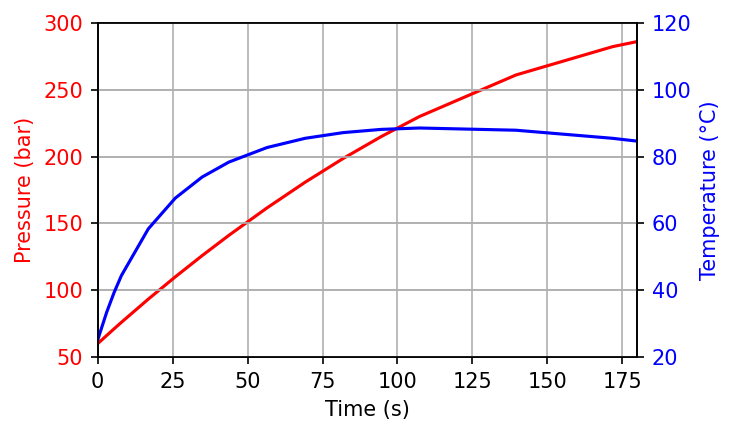

In [5]:
pressures = np.zeros(len(sol.y[0]))
temperatures = np.zeros(len(sol.y[0]))

for idx in range(len(sol.y[0])):
    mass = Q_(sol.y[0][idx], 'kg')
    internal_energy = Q_(sol.y[1][idx], 'J')
    
    volume_tank = np.pi * tank['height'] * tank['diameter']**2 / 4.0
    
    # calculate specific volume and specific internal energy
    # based on mass and (total) internal energys
    specific_volume = (tank['number'] * volume_tank) / mass
    specific_internal_energy = internal_energy / mass
    f = ct.Hydrogen()
    f.UV = (
        specific_internal_energy.to('J/kg').magnitude, 
        specific_volume.to('m^3/kg').magnitude
        )
    
    pressures[idx] = f.P
    temperatures[idx] = f.T
    
pressures *= ureg.Pa
temperatures *= ureg.K

fig, ax1 = plt.subplots(figsize=(5, 3))

color = 'red'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pressure (bar)', color=color)
ax1.plot(sol.t, pressures.to('bar').magnitude, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axis([0, 180, 50, 300])
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
# we already handled the x-label with ax1
ax2.set_ylabel('Temperature (°C)', color=color)
ax2.plot(sol.t, temperatures.to('degC').magnitude, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axis([0, 180, 20, 120])
ax2.grid(True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Now plot the mass of fuel added as a function of time:

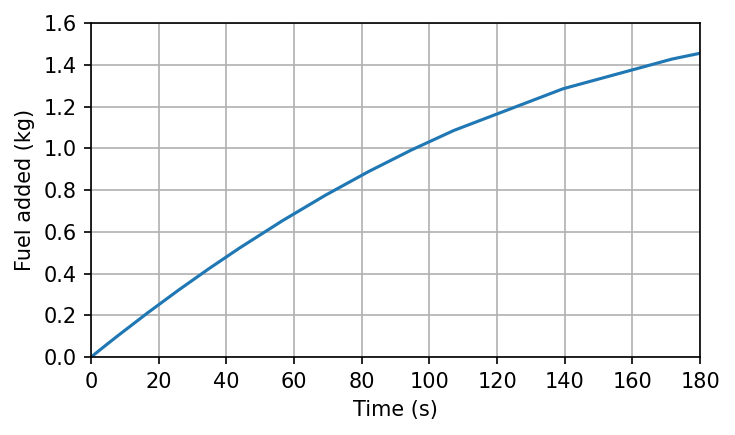

In [6]:
mass_added = sol.y[0] - mass_initial.to('kg').magnitude
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(sol.t, mass_added)
plt.xlabel('Time (s)')
plt.axis([0, 180, 0, 1.6])
plt.ylabel('Fuel added (kg)')
plt.grid(True)
fig.tight_layout()
plt.show()